# Homework 2: Unsupervised Representation Learning
**By:** Scott Brown

# Part 1: Frey Face Compression and Generation

In [66]:
# Program Imports
import numpy as np
import matplotlib as mpl
import tensorflow as tf
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

from tensorflow.keras.utils import get_file
from scipy.io import loadmat

# Unpack frey dataset
path = get_file('frey_rawface.mat','https://cs.nyu.edu/~roweis/data/frey_rawface.mat')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))

np.random.seed(1234)
np.random.shuffle(images)

# Train images
x_train = images[0:1800]
x_test = images[1800:]
x_train = (x_train.astype('float32')/255.)*2-1
x_test = (x_test.astype('float32')/255.)*2-1

## 1.1 Autoencoder Setup and Training
- MLP for encoder and decoder
- 2D latent space
- Hidden layers equipped with ReLu, except encoder final layer which is equipped with tanh 

In [67]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_encoder(latent_dim):
  inputs = Input((28,20),name='encoder_input')
  flat = Flatten()(inputs) # flatten to a vector
  embedding = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(latent_dim,activation='tanh')
  ])(flat)
  return Model(inputs=inputs,outputs=embedding)

def build_decoder(latent_dim):
  inputs = Input(latent_dim,name='decoder_input')
  reconstruction = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(28*20, activation=None)
  ])(inputs)
  reshaped = Reshape((28,20))(reconstruction) # reshape back to an image
  return Model(inputs=inputs,outputs=reshaped)

def build_autoencoder(encoder,decoder):
  inputs = Input((28,20),name='autoencoder_input')
  embedding = encoder(inputs)
  reconstruction = decoder(embedding)
  return Model(inputs=inputs,outputs=reconstruction)

latent_dim = 2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
autoencoder = build_autoencoder(encoder,decoder)

opt = Adam(3e-4)
autoencoder.compile(opt,loss='mean_squared_error')

history = autoencoder.fit(x_train,x_train,batch_size=32,epochs=300,verbose=False,validation_split=0.1)

## 1.2 Analysis and Visualization
- Compare images
- Visualize output as a scatter plot
- Generate new faces
- Test interpolation between 2 images

57/57 [==============================] - 0s 546us/step


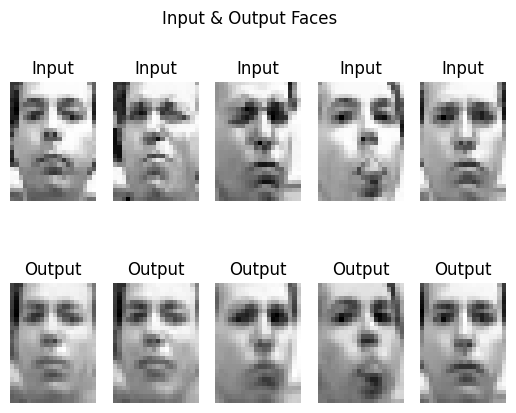

In [68]:
# Compress and decompress data
result = autoencoder.predict(x_train)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i],cmap='gray')
  plt.title("Input")
  plt.axis('off')
  plt.subplot(2,5,5+i+1)
  plt.imshow(result[i],cmap='gray')
  plt.title("Output")
  plt.axis('off')
plt.suptitle("Input & Output Faces")
plt.show()

The autoencoder yields a smoothing effect on the images, blurring the image slightly and reducing the sharpness. Comparing the output of the autoencoder to the linear autoencoder provided by Dr. Ventura, the autoencoder tends to generate faces with darker eyes and happier countenances.

57/57 [==============================] - 0s 482us/step


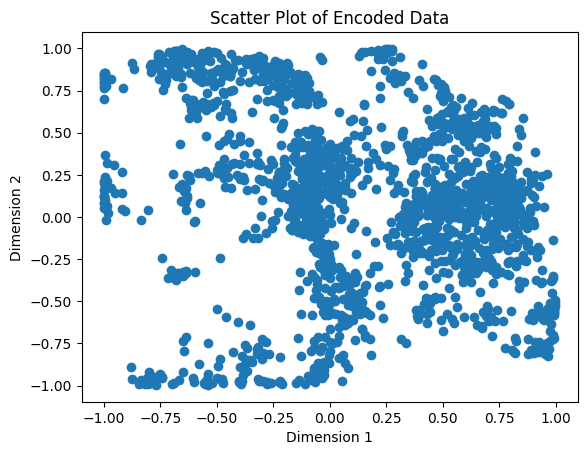

In [69]:
# Visualize encoder output as scatter
encoder_result = encoder.predict(x_train)
plt.scatter(encoder_result[:,0],encoder_result[:,1])
plt.title('Scatter Plot of Encoded Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

The encoder output visualized in the above scatterplot illustrates that the model seems to be using much of the possible output space as the outputs range from -1 to 1 in both dimensions. There is some unused space at the top of the figure, which could signify a lack of efficiency in the model.

2/2 [==============================] - 0s 1ms/step


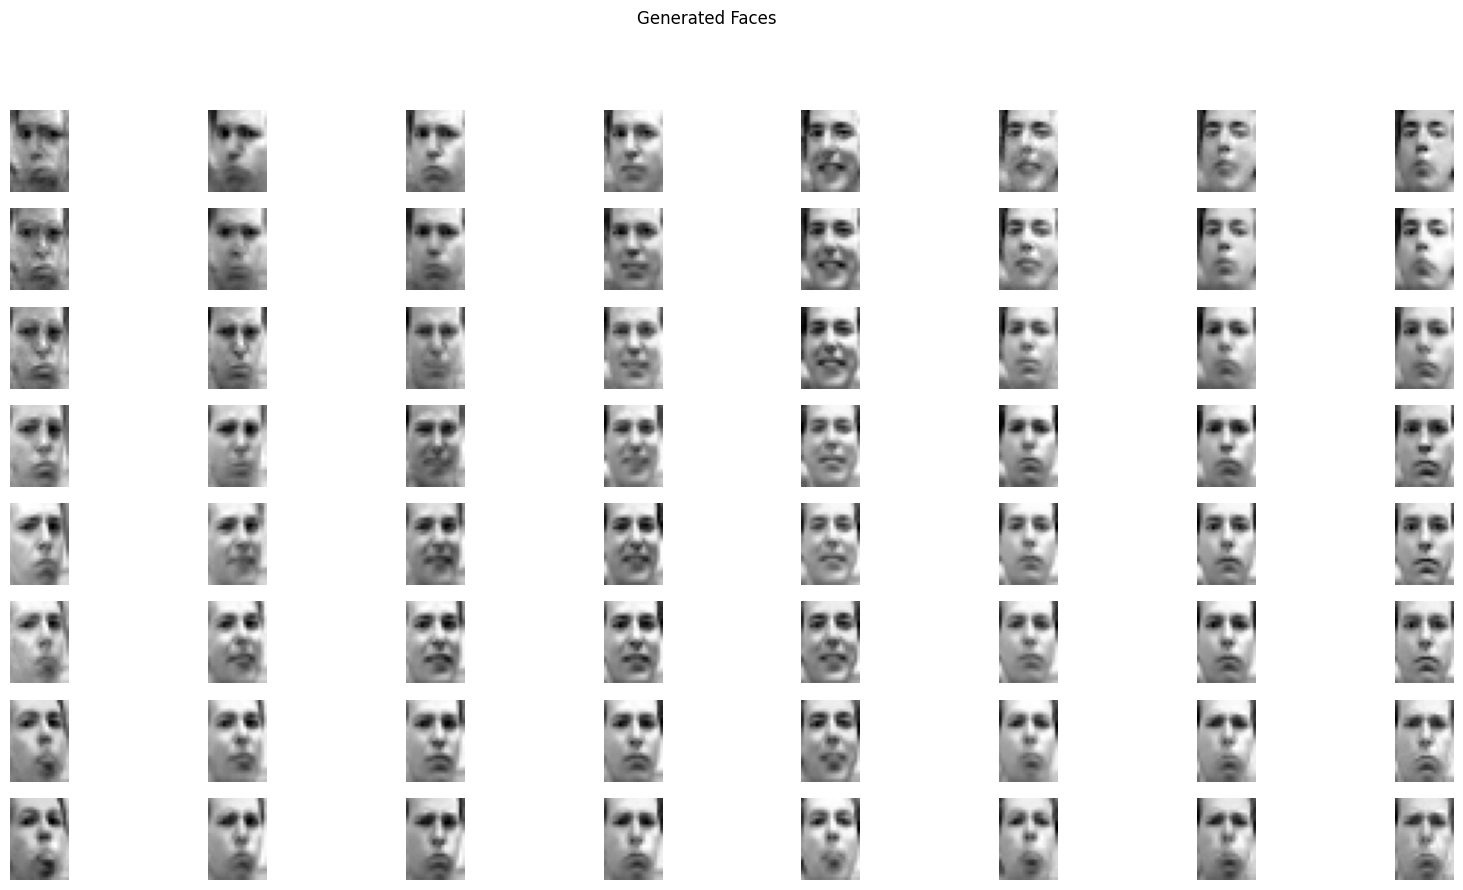

In [70]:
# Generate new faces
nx, ny = (8, 8)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
xv, yv = np.meshgrid(x, y)
mesh_embeddings = np.column_stack((xv.flatten(), yv.flatten()))

plt.figure(figsize=(20,10))
decoder_result = decoder.predict(mesh_embeddings)
n = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8,8,n+1)
    plt.imshow(decoder_result[n],cmap='gray')
    plt.axis('off')
    n = n + 1
plt.suptitle("Generated Faces")
plt.show()

The set of faces generated in the above graphic demonstrates the ability of the model to construct faces from a set of arbitrary predications. As faces are generated left to right across the figure, the faces seem to rotate about a front axis, with the rightmost and leftmose faces all posed facing inwards. Facial expression subsequently ranges in the vertical axis, with the faces expressing neutrality, happiness and other expressions.

1/1 [==============================] - 0s 12ms/step
[[ 0.27327132 -0.49906987]]
1/1 [==============================] - 0s 12ms/step


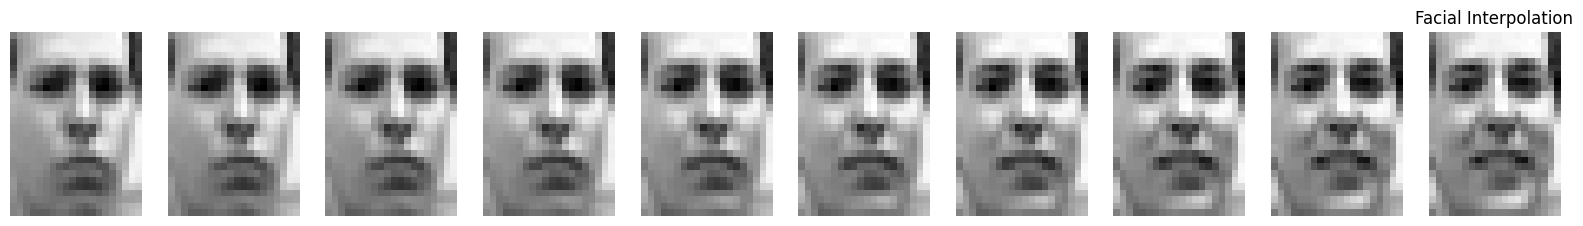

In [71]:
# Test interpolation between 2 images
def interpolate_between(imgA_index,imgB_index):
  plt.figure(figsize=(20,10))
  imgA = x_test[imgA_index]
  imgB = x_test[imgB_index]

  imgA_encoded = encoder.predict(x_test[imgA_index:(imgA_index+1)])
  imgB_encoded = encoder.predict(x_test[imgB_index:(imgB_index+1)])

  direction = imgB_encoded - imgA_encoded
  print(direction)

  alphas = np.linspace(0,1,num=10)
  for n in range(10):
    alpha = alphas[n]
    img_encoded = (1-alpha)*imgA_encoded+alpha*imgB_encoded
    img = decoder.predict(img_encoded)
    plt.subplot(1,10,n+1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
  plt.title("Facial Interpolation")
  plt.show()

interpolate_between(0,2)

The interpolations of the the images demonstrates a gradient from a frown to a smile. This gradient is similair to that demonstrated in the linear encoder, though these faces seem to posses a less 'uncanny valleyness' than those constructed from the linear encoder model.

# Part 2: MNIST Digit Classification with Unsupervised Pre-Training

Epoch 1/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0610 - val_loss: 0.0400
Epoch 2/50
357/357 [==============================] - 1s 1ms/step - loss: 0.0337 - val_loss: 0.0309
Epoch 3/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0294
Epoch 4/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0286
Epoch 5/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0281
Epoch 6/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0278
Epoch 7/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0275
Epoch 8/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0273
Epoch 9/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0271
Epoch 10/50
357/357 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0268

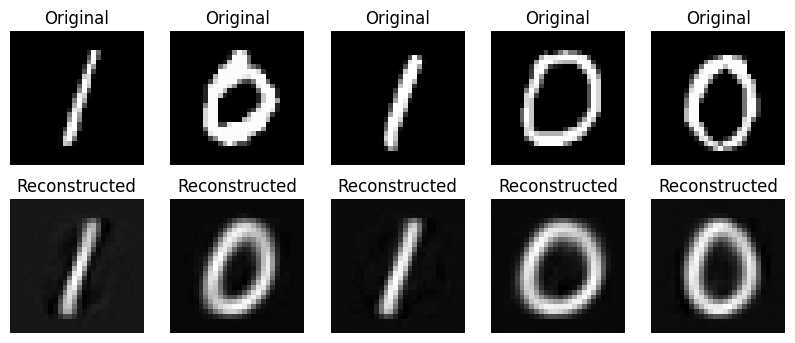

In [72]:
# Part 2
# Train MNIST data set

from keras.datasets import mnist
# Load MNIST dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

# Filter out only digits 0 and 1
selected_digits = [0, 1]
indices_train = np.isin(y_train_full, selected_digits)
indices_test = np.isin(y_test_full, selected_digits)

x_train = x_train_full[indices_train]
x_test = x_test_full[indices_test]

# Preprocess the data
x_train = (x_train.astype('float32')/255.)
x_test = (x_test.astype('float32')/255.)

# Resize data to 28x28
x_train = x_train.reshape((len(x_train), 28, 28))
x_test = x_test.reshape((len(x_test), 28, 28))

# Build autoencoder
def build_encoder(latent_dim):
  inputs = Input((28,28),name='encoder_input')
  flat = Flatten()(inputs) # flatten to a vector
  embedding = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(latent_dim,activation='tanh')
  ])(flat)
  return Model(inputs=inputs,outputs=embedding)

def build_decoder(latent_dim):
  inputs = Input(latent_dim,name='decoder_input')
  reconstruction = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(28*28, activation=None)
  ])(inputs)
  reshaped = Reshape((28,28))(reconstruction) # reshape back to an image
  return Model(inputs=inputs,outputs=reshaped)

def build_autoencoder(encoder,decoder):
  inputs = Input((28,28),name='autoencoder_input')
  embedding = encoder(inputs)
  reconstruction = decoder(embedding)
  return Model(inputs=inputs,outputs=reconstruction)

latent_dim = 2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
autoencoder = build_autoencoder(encoder,decoder)

# Compile
opt = Adam(3e-4)
autoencoder.compile(opt,loss='mean_squared_error')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)

# Reconstruct images using the trained autoencoder
x_reconstructed = autoencoder.predict(x_test)

# Display original and reconstructed images
n = 5  # Number of images to compare
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original Images
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed Images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_reconstructed[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()


In [73]:
from keras.utils import to_categorical

# Obtain embedding vectors of training and testing images

mnist_train_embed = encoder.predict(x_train)
mnist_test_embed = encoder.predict(x_test)

# Build classifier
def build_classifier(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    outputs = Dense(output_dim, activation='softmax')(inputs)
    classifier = Model(inputs, outputs)
    return classifier

# Compile classifier
input_dim = latent_dim  # Dimension of the embedding vector
output_dim = np.size(selected_digits)  # Number of classes (digits 0 and 1)
print(output_dim)
classifier = build_classifier(input_dim, output_dim)

opt = Adam(3e-4)
classifier.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train network on embedding vectors
y_train_one_hot = to_categorical(y_train_full[indices_train])
y_test_one_hot = to_categorical(y_test_full[indices_test])

# Train the classifier
classifier.fit(mnist_train_embed, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Step 4: Evaluate the classification model on the testing data
evaluation = classifier.evaluate(mnist_test_embed, y_test_one_hot)

test_accuracy = evaluation[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

67/67 [==============================] - 0s 447us/step


2
Epoch 1/20
357/357 [==============================] - 0s 788us/step - loss: 0.6762 - accuracy: 0.5669 - val_loss: 0.6522 - val_accuracy: 0.7032
Epoch 2/20
357/357 [==============================] - 0s 549us/step - loss: 0.6221 - accuracy: 0.7892 - val_loss: 0.6017 - val_accuracy: 0.8587
Epoch 3/20
357/357 [==============================] - 0s 544us/step - loss: 0.5744 - accuracy: 0.8788 - val_loss: 0.5563 - val_accuracy: 0.9290
Epoch 4/20
357/357 [==============================] - 0s 547us/step - loss: 0.5314 - accuracy: 0.9360 - val_loss: 0.5152 - val_accuracy: 0.9724
Epoch 5/20
357/357 [==============================] - 0s 547us/step - loss: 0.4924 - accuracy: 0.9582 - val_loss: 0.4778 - val_accuracy: 0.9795
Epoch 6/20
357/357 [==============================] - 0s 550us/step - loss: 0.4570 - accuracy: 0.9734 - val_loss: 0.4436 - val_accuracy: 0.9834
Epoch 7/20
357/357 [==============================] - 0s 543us/step - loss: 0.4246 - accuracy: 0.9804 - val_loss: 0.4124 - val_accurac

From the training of the MNIST data set a training accuracy of 99.95% has been achieved. This demonstrates that pre-training on the embedding vectors yields a high accuracy.